In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import label2rgb
from skimage import img_as_ubyte
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [32]:
# Read the original image
image = cv2.imread('/content/00000048.jpg')

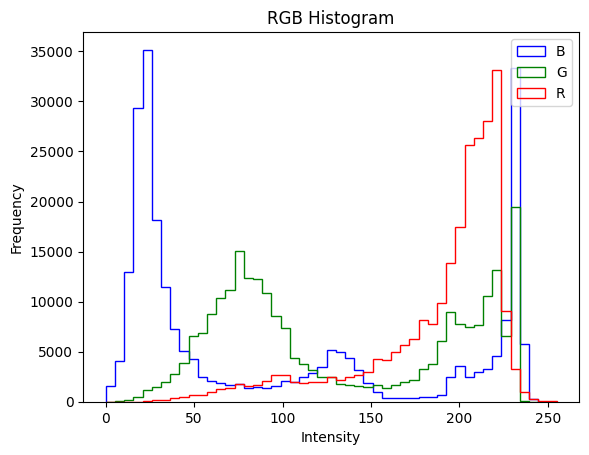

In [33]:
# Split the RGB image into channels
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
r = np.concatenate(rgb_image[:,:,0])
g = np.concatenate(rgb_image[:,:,1])
b = np.concatenate(rgb_image[:,:,2])
bins = np.linspace(0, 255, 50)

# Define bins and plot histogram
plt.hist([r, g, b], bins, label=['R', 'G', 'B'], color=['r', 'g', 'b'], histtype='step')
plt.legend(loc='upper right')
plt.title("RGB Histogram")
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

In [34]:
# Convert BGR to HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Extract the Hue channel
hue_channel = hsv_image[:, :, 0]

# Apply contrast stretching to the Hue channel
min_val = np.min(hue_channel)
max_val = np.max(hue_channel)
hue_stretched = cv2.normalize(hue_channel, None, min_val, max_val, cv2.NORM_MINMAX)

# Combine the stretched Hue channel with original Saturation and Value channels
hsv_stretched = cv2.merge([hue_stretched, hsv_image[:, :, 1], hsv_image[:, :, 2]])
rgb_stretched = cv2.cvtColor(hsv_stretched, cv2.COLOR_HSV2RGB)

In [35]:
# Mean Shift Clustering algorithm
v = np.float32(rgb_stretched.reshape((-1, 3)))

# Estimate bandwidth with a minimum value and fit the model
bandwidth = max(estimate_bandwidth(v, quantile=.04, n_samples=1000), 1.0)
model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels = model.fit_predict(v)
im_labels = labels.reshape(rgb_stretched.shape[:2])
im_labels_rgb = label2rgb(im_labels)

# Store the segmented image
segmented_image = img_as_ubyte(im_labels_rgb)

In [36]:
# Overlay segmented regions on the original image
overlay = cv2.addWeighted(image, 0.6, segmented_image, 0.4, 0)

In [37]:
# Convert the segmented image to grayscale
segmented_gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)

# Apply morphological processing with a median filter
kernel_size = 5
median_filtered = cv2.medianBlur(segmented_gray, kernel_size)

In [38]:
# Load the ground truth image
ground_truth_path = "/content/00000048.png"
ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

In [39]:
# Convert ground truth to binary
ground_truth_binary = (ground_truth > 0)

# Convert median_filtered to binary
median_filtered_binary = (median_filtered > 0)

# Calculate mIoU for binary segmentation
def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_miou(gt_image, pred_image):
    unique_classes = np.unique(gt_image)
    miou_scores = [calculate_iou(gt_image == class_id, pred_image == class_id) for class_id in unique_classes]
    mIoU = np.mean(miou_scores)
    return mIoU

miou = calculate_miou(ground_truth_binary, median_filtered_binary)

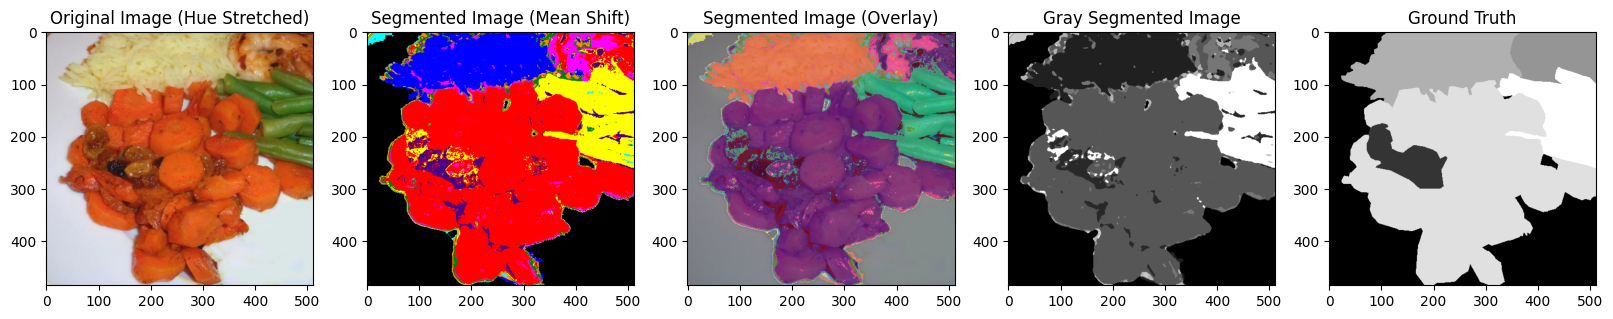

mIoU Score: 0.9501


In [40]:
# Display the original, segmented, post-processed images and ground truth along with mIoU Score
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.imshow(rgb_stretched)
plt.title('Original Image (Hue Stretched)')

plt.subplot(1, 5, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image (Mean Shift)')

plt.subplot(1, 5, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image (Overlay)')

plt.subplot(1, 5, 4)
plt.imshow(median_filtered, cmap='gray')
plt.title('Gray Segmented Image')

plt.subplot(1, 5, 5)
plt.imshow(ground_truth, cmap='gray')
plt.title('Ground Truth')

plt.show()

print(f"mIoU Score: {miou:.4f}")